In [1]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, 
                              pauli_error, depolarizing_error, thermal_relaxation_error)

### Entanglement hub

Assume a situation where Alice and Bob cannot share an entangled qubit directly but they can share entangled qubit with Henry (stand for hub) respectively.  Henry can teleport his Alice-Henry entangled qubit to Bob so that Alice and Bob get shared entangled qubit effectively.

In [3]:
def do_entangle(qc, reg1, reg2):
    """
    Creates an entangled Bell state between two qubits 1/sqrt(2)(|00> + |11>)

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to add the entanglement operations to
    reg1 : QuantumRegister
        First qubit to be entangled
    reg2 : Quant
        Second qubit to be entangled

    Returns:
    --------
    None
        Modifies the quantum circuit in place
    """
    qc.initialize("0", reg1)
    qc.initialize("0", reg2)
    qc.h(reg1)
    qc.cx(reg1, reg2)

In [4]:
def do_hub(qc, enareg, enahreg, enbhreg, enbreg, c_tpreg):
    """
    Implements a quantum hub protocol using quantum teleportation to transfer quantum states 
    through an intermediate hub node.

    Initially, enareg and enahreg are entangled (Alice-Henry), enbhreg and enbreg are entangled (Bob-Henry).
    The function performs quantum teleportation from Alice's hub qubit (enahreg) to Bob (enbreg).  
    Effectively make Alice (enareg) and Bob (enbreg) entangled.

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to add the teleportation operations to
    enareg : QuantumRegister
        Alice's qubit register
    enahreg : QuantumRegister
        Alice's hub qubit register
    enbhreg : QuantumRegister
        Bob's hub qubit register
    enbreg : QuantumRegister
        Bob's qubit register
    c_tpreg : ClassicalRegister[2]
        Classical register to store teleportation measurement results
        c_tpreg[0]: First measurement result
        c_tpreg[1]: Second measurement result

    Returns:
    --------
    None
        Modifies the quantum circuit in place
    """
    # teleport ahreg (henry on alice-henry entangled qubit) to breg (bob)
    qc.cx(enahreg, enbhreg)
    qc.h(enahreg)
    qc.measure(enbhreg, c_tpreg[0])
    qc.measure(enahreg, c_tpreg[1])

    with qc.if_test((c_tpreg[0], 1)):
        qc.x(enbreg)
    with qc.if_test((c_tpreg[1], 1)):
        qc.z(enbreg)

Prepare circuit to test the hub.

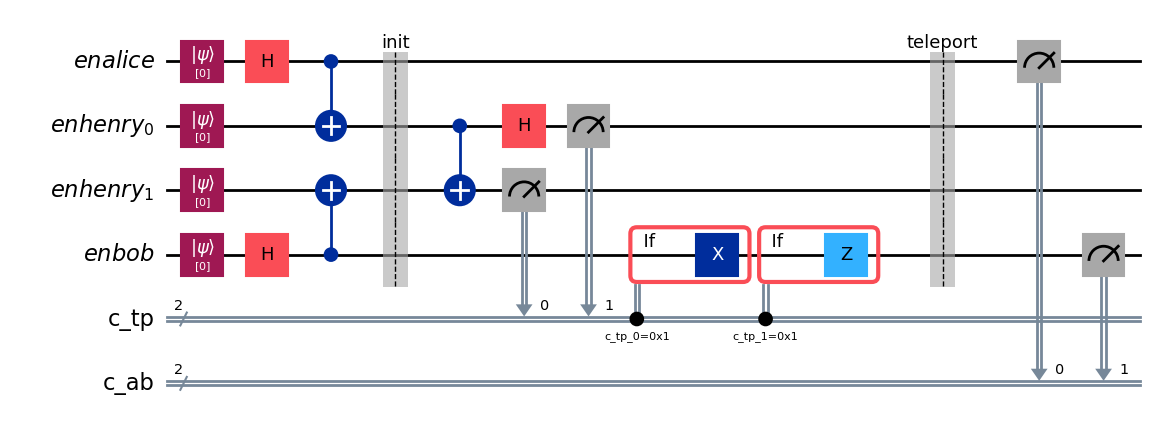

In [5]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
enareg = QuantumRegister(1, "enalice")
enbreg = QuantumRegister(1, "enbob")
enhreg = QuantumRegister(2, "enhenry")      # h stand for hub
c_tpreg = ClassicalRegister(2, "c_tp")  # tp stand for teleport
c_abreg = ClassicalRegister(2, "c_ab")
qc = QuantumCircuit(enareg, enhreg, enbreg, c_tpreg, c_abreg)

do_entangle(qc, enareg, enhreg[0])
do_entangle(qc, enbreg, enhreg[1])
qc.barrier(label='init')
do_hub(qc, enareg, enhreg[0], enhreg[1], enbreg, c_tpreg)
qc.barrier(label='teleport')

# verify if Alice and Bob share an entangled qubit
qc.measure(enareg, c_abreg[0])
qc.measure(enbreg, c_abreg[1])

qc.draw('mpl')

Verify if Alice-Bob is entangled.

In [6]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc])
result = job.result()[0]
samp = result.data.c_ab.get_counts()
print(samp)

{'11': 513, '00': 511}


Illustrate E91 protocol with hub.

In [7]:
def do_e91_with_hub(qc, areg, breg, enareg, enbreg, c_a, c_b, c_ena, c_enb, c_eve, eve_rate, enahreg, enbhreg, c_tpreg):
    """
    Implements the E91 (Ekert91) quantum key distribution protocol using quantum circuits.
    
    The protocol creates entangled pairs and performs measurements along different bases
    to establish a shared secret key between Alice and Bob. It uses Bell states and
    measurements along three different angles: z-basis (0°), z+x basis (45°), and 
    x-basis/z-x basis (90°/-90°) for Alice and Bob respectively.

    Parameters:
        qc (QuantumCircuit): Quantum circuit for implementing the protocol
        areg (QuantumRegister): 2-qubit register for Alice's basis selection
        breg (QuantumRegister): 2-qubit register for Bob's basis selection
        enareg (QuantumRegister): Single-qubit register for Alice's entangled qubit
        enbreg (QuantumRegister): Single-qubit register for Bob's entangled qubit
        c_a (ClassicalRegister): 2-bit register to store Alice's basis choice
        c_b (ClassicalRegister): 2-bit register to store Bob's basis choice
        c_ena (ClassicalRegister): Register for Alice's measurement result
        c_enb (ClassicalRegister): Register for Bob's measurement result
        c_eve (ClassicalRegister): Optional register for Eve's measurement (for simulation)
        eve_rate (float): Probability of Eve's intervention (0 to 1)
        enahreg (QuantumRegister): Single-qubit hub entangled to Alice
        enbhreg (QuantumRegister): Single-qubit hub entangled to Bob
        c_tpreg (ClassicalRegister): Classical register for hub's teleportation results

    Protocol Steps:
    1. Initialize all qubits to |0⟩ state
    2. Create superposition for basis selection using Hadamard gates
    3. Generate entangled Bell state between Alice and Bob's qubits through Henry's qubits
    4. Measure basis choices for Alice and Bob
    5. Perform measurements along three different angles:
       - Alice: z-basis (0°), z+x basis (45°), x-basis (90°)
       - Bob: z-basis (0°), z+x basis (45°), z-x basis (-45°)
    6. Optional: Simulate eavesdropper (Eve) measurements

    Measurement Bases:
    - 00: z-basis (0°)
    - 01: z+x basis (45°)
    - 10, 11: x-basis (90°) for Alice, z-x basis (-45°) for Bob

    Note: The function uses conditional operations (if_test) to perform different 
    measurements based on the randomly selected bases.
    (gen by Amazon Q)
    """
    qc.initialize([1, 0, 0, 0], areg)
    qc.initialize([1, 0, 0, 0], breg)
    qc.h(areg)
    qc.h(breg)
    qc.barrier()

    # Alice and Bob entangled with hub
    do_entangle(qc, enareg, enahreg)    # Alice-Henry entangled
    qc.barrier(label='a-h')
    do_entangle(qc, enbreg, enbhreg)    # Bob-Henry entangled
    qc.barrier(label='b-h')
    do_hub(qc, enareg, enahreg, enbhreg, enbreg, c_tpreg)   # Alice-Bob entangled
    qc.barrier(label='do_hub')
    
    # randomly generate 2 bits for Alice
    qc.measure(areg, c_a)
    with qc.if_test((c_a[1], 0)) as else_:
        with qc.if_test((c_a[0], 0)) as else1_:
            # measure along z
            qc.measure(enareg, c_ena)
        with else1_:
            # measure along z+x
            qc.ry(-math.pi/4, enareg)
            qc.measure(enareg, c_ena)
            qc.ry(math.pi/4, enareg)
    with else_:
        # measure along x
        qc.ry(-math.pi/2, enareg)
        qc.measure(enareg, c_ena)
        qc.ry(math.pi/2, enareg)
    qc.barrier(label='alice')

    if c_eve is not None:
        if random.random() < eve_rate:
            qc.measure(enbreg, c_eve)

    # randomly generate 2 bits for Bob
    qc.measure(breg, c_b)
    with qc.if_test((c_b[1], 0)) as else_:
        with qc.if_test((c_b[0], 0)) as else1_:
            # measure along z
            qc.measure(enbreg, c_enb)
        with else1_:
            # measure along z+x
            qc.ry(-math.pi/4, enbreg)
            qc.measure(enbreg, c_enb)
            qc.ry(math.pi/4, enbreg)
    with else_:
        # measure along z-x
        qc.ry(math.pi/4, enbreg)
        qc.measure(enbreg, c_enb)
        qc.ry(-math.pi/4, enbreg)
    qc.barrier(label='bob')

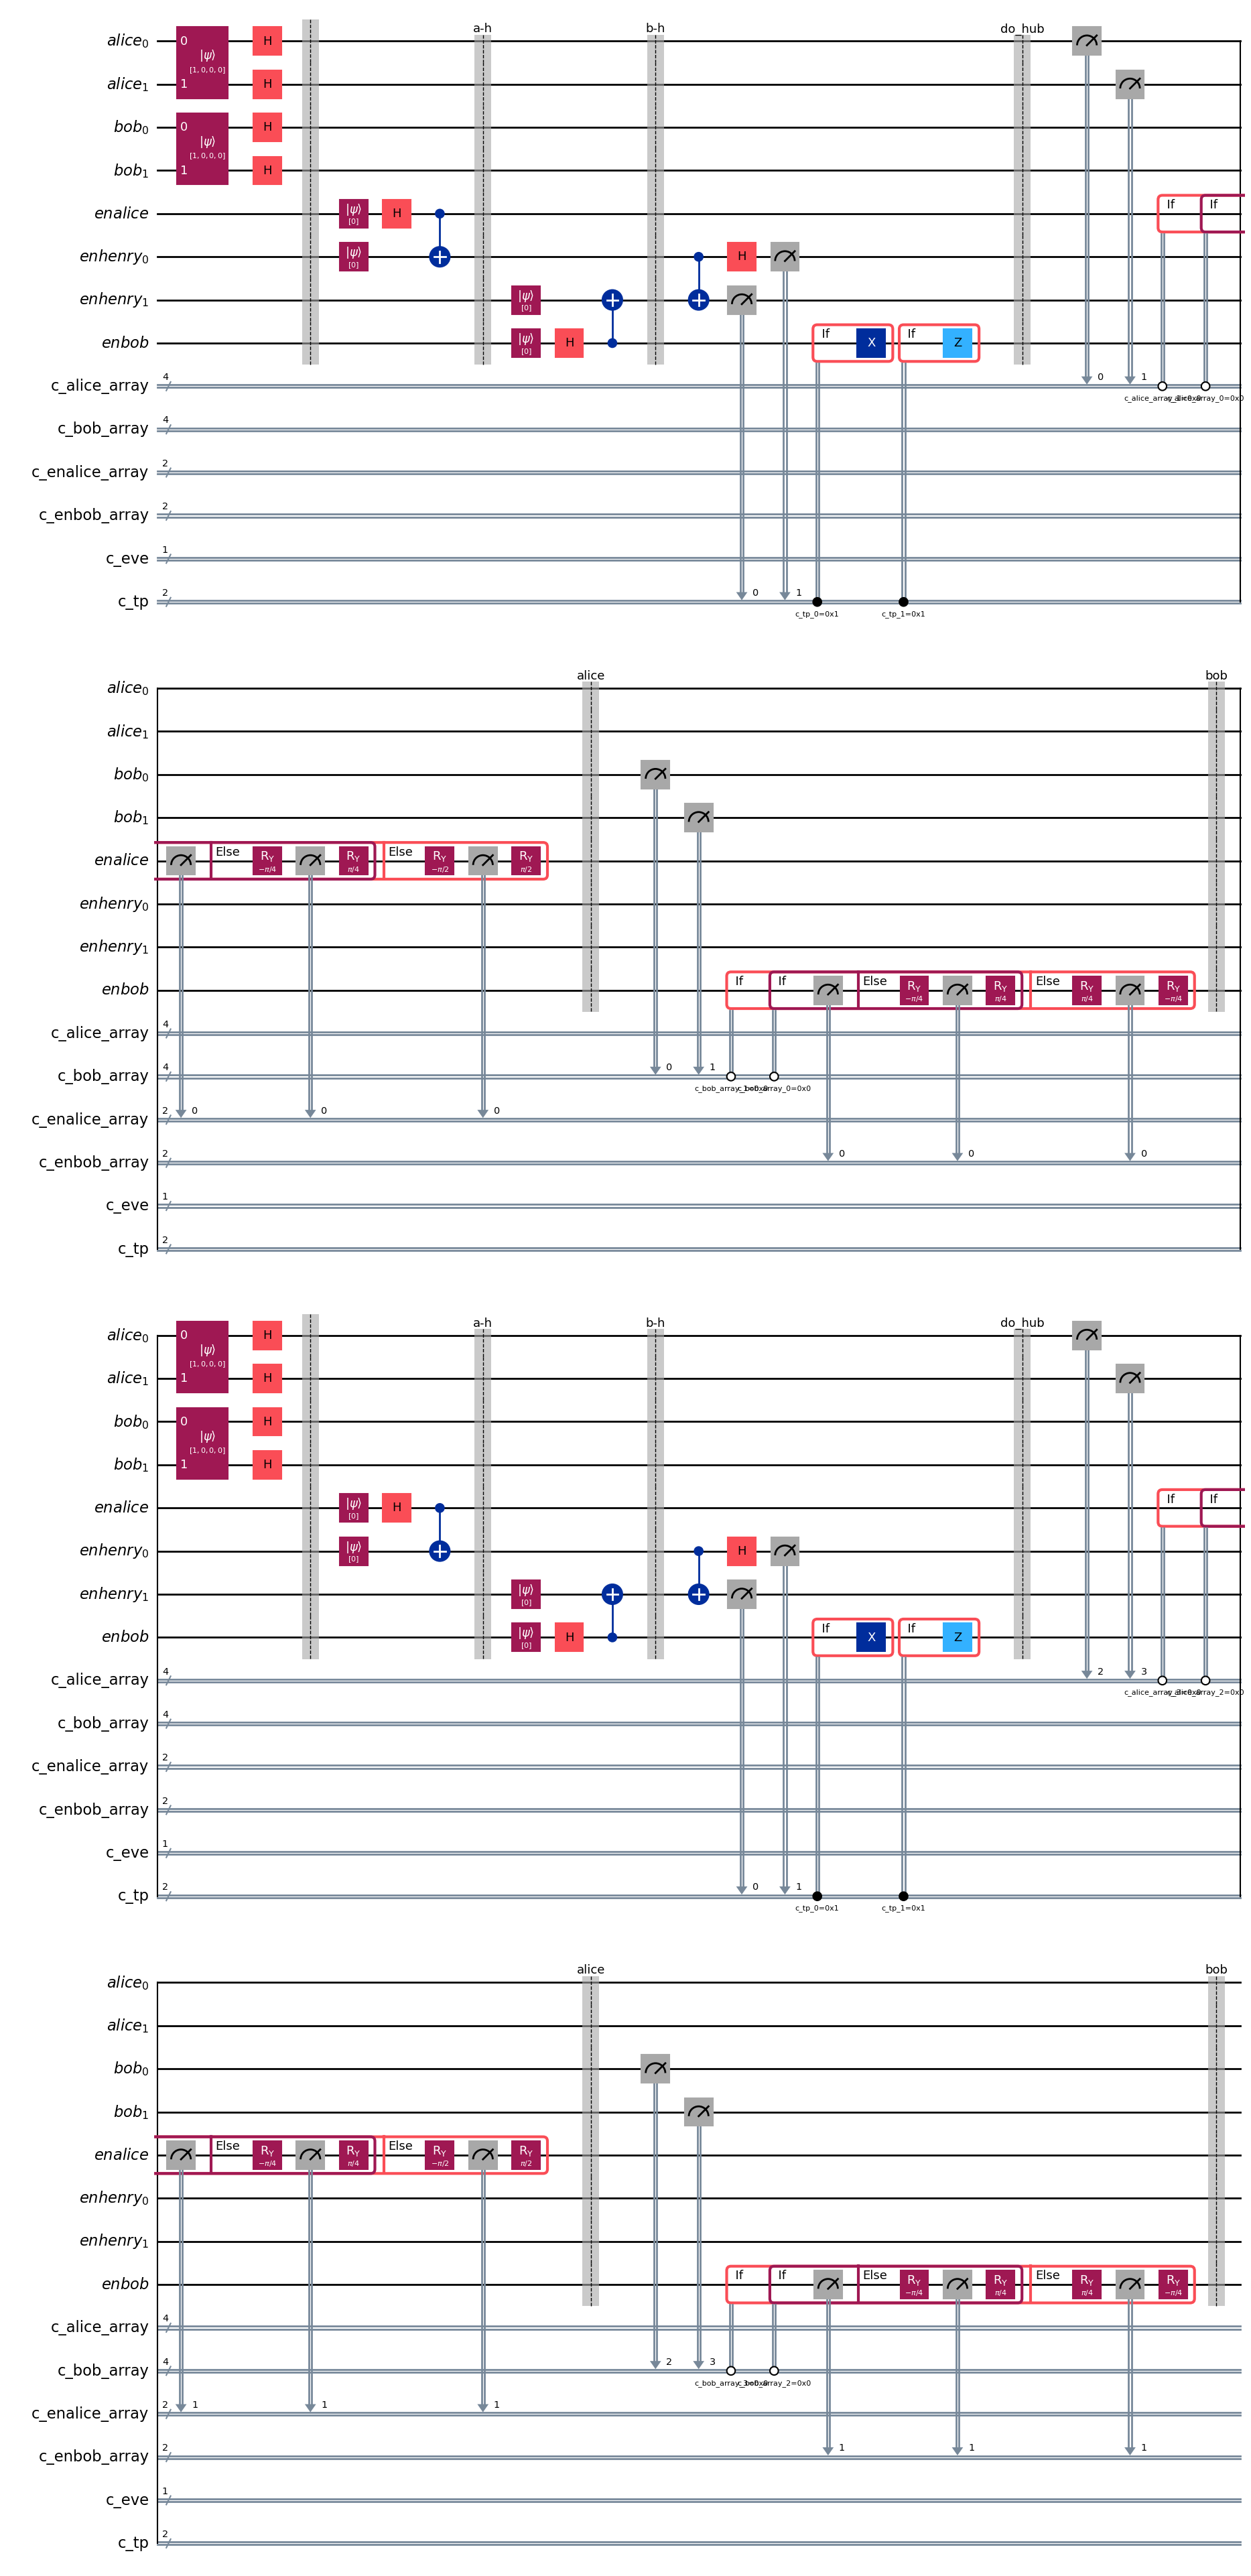

In [8]:
N = 2
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
enhreg = QuantumRegister(2, "enhenry")      # henry as a hub
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure
c_tpreg = ClassicalRegister(2, "c_tp")      # for teleport measurement

qc = QuantumCircuit(areg, breg, enareg, enhreg, enbreg, c_a_arrayreg, c_b_arrayreg, c_ena_arrayreg, c_enb_arrayreg, 
                    c_evereg, c_tpreg)

for i in range(N):
    do_e91_with_hub(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
                    c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, 0, enhreg[0], enhreg[1], c_tpreg)

display(qc.draw('mpl'))

Run E91 protocol with hub.

In [9]:
N = 2000
areg = QuantumRegister(2, "alice")          # for generating 2 random classical bits for alice
breg = QuantumRegister(2, "bob")            # for generating 2 random classical bits for bob
enareg = QuantumRegister(1, "enalice")      # alice part of entangled qubit
enbreg = QuantumRegister(1, "enbob")        # bob part of entangled qubit
enhreg = QuantumRegister(2, "enhenry")      # henry as a hub
c_a_arrayreg = ClassicalRegister(2*N, "c_alice_array")  # record alice randomly generated axis code, 2 bits each
c_b_arrayreg = ClassicalRegister(2*N, "c_bob_array")    # record bob randomly generated axis code, 2 bits each
c_ena_arrayreg = ClassicalRegister(N, "c_enalice_array")    # record alice measured value
c_enb_arrayreg = ClassicalRegister(N, "c_enbob_array")      # record bob measured value
c_evereg = ClassicalRegister(1, "c_eve")    # for eve eavesdrop measure
c_tpreg = ClassicalRegister(2, "c_tp")      # for teleport measurement

qc = QuantumCircuit(areg, breg, enareg, enhreg, enbreg, c_a_arrayreg, c_b_arrayreg, c_ena_arrayreg, c_enb_arrayreg, 
                    c_evereg, c_tpreg)

for i in range(N):
    do_e91_with_hub(qc, areg, breg, enareg, enbreg, c_a_arrayreg[2*i:2*i+2], c_b_arrayreg[2*i:2*i+2], 
                    c_ena_arrayreg[i], c_enb_arrayreg[i], c_evereg, 0, enhreg[0], enhreg[1], c_tpreg)

# display(qc.draw('mpl'))

The following codes are copied from [Chapter 2](02_e91.ipynb).

In [10]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc], shots=1)
result = job.result()[0]
samp_alice = result.data.c_alice_array.get_counts()
samp_bob = result.data.c_bob_array.get_counts()
samp_enalice = result.data.c_enalice_array.get_counts()
samp_enbob = result.data.c_enbob_array.get_counts()
# print(samp_alice, samp_bob)
# print(samp_enalice, samp_enbob)

In [11]:
# reverse string to turn qiskit bit 0 (rightmost bit) to *_array[0]
alice_array = list(samp_alice.keys())[0][::-1]
bob_array = list(samp_bob.keys())[0][::-1]
enalice_array = list(samp_enalice.keys())[0][::-1]
enbob_array = list(samp_enbob.keys())[0][::-1]
# print(alice_array, bob_array)
# print(enalice_array, enbob_array)

In [12]:
def calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array):
    """
    Calculates alice key, bob key and S statistic for the E91 protocol.
    
    This function analyzes the measurement results from an E91 quantum key distribution
    protocol implementation to:
    1. Calculate the keys from Alice and Bob's measurements
    2. Compute the S parameter for Bell's inequality test
    
    Parameters:
        alice_array (str): String containing Alice's basis choices
                          Format: Sequence of 2-bit strings
                          - '00': z basis
                          - '10': z+x basis
                          - '01', '11': x basis
        
        bob_array (str): String containing Bob's basis choices
                        Format: Sequence of 2-bit strings
                        - '00': z basis
                        - '10'': z+x basis
                        - '01', '11': z-x basis
        
        enalice_array (str): String containing Alice's measurement results
                            Format: Sequence of single bits ('0' or '1')
                            - '0': Spin up/+1 measurement
                            - '1': Spin down/-1 measurement
        
        enbob_array (str): String containing Bob's measurement results
                          Format: Sequence of single bits ('0' or '1')
                          - '0': Spin up/+1 measurement
                          - '1': Spin down/-1 measurement
    Returns:
        tuple: (alice_key, bob_key, s_param)
            - alice_key (str): Alice's key string
            - bob_key (str): Bob's key string
            - s_stat (float): Calculated S statistic for Bell's inequality test
    """
    alice_key = []
    bob_key = []
    correlate_count = [0, 0, 0, 0]
    correlate_value = [0, 0, 0, 0]
    for i in range(len(enalice_array)):
        # check if both alice and bob are "00" or "10"
        if (alice_array[2*i:2*i+2] == "00" and bob_array[2*i:2*i+2] == "00") or (alice_array[2*i:2*i+2] == "10" and bob_array[2*i:2*i+2] == "10"):
            alice_key.append(enalice_array[i])
            bob_key.append(enbob_array[i])
        if enalice_array[i] == '0':
            a_value = 1
        else:
            a_value = -1
        if enbob_array[i] == '0':
            b_value = 1
        else:
            b_value = -1
        if alice_array[2*i:2*i+2] == "00" and bob_array[2*i:2*i+2] == "10": 
            # alice z, bob z+x
            correlate_value[0] += a_value*b_value
            correlate_count[0] += 1
        if alice_array[2*i:2*i+2] == "00" and (bob_array[2*i:2*i+2] == "01" or bob_array[2*i:2*i+2] == "11"):
            # alice z, bob z-x
            correlate_value[1] += a_value*b_value
            correlate_count[1] += 1
        if (alice_array[2*i:2*i+2] == "01" or alice_array[2*i:2*i+2] == "11") and bob_array[2*i:2*i+2] == "10":
            # alice x, bob z+x
            correlate_value[2] += a_value*b_value
            correlate_count[2] += 1
        if (alice_array[2*i:2*i+2] == "01" or alice_array[2*i:2*i+2] == "11") and (bob_array[2*i:2*i+2] == "01" or bob_array[2*i:2*i+2] == "11"):
            # alice x, bob z-x
            correlate_value[3] -= a_value*b_value
            correlate_count[3] += 1

    s_stat = 0
    for i, c in enumerate(correlate_count):
        if c != 0:
            s_stat += correlate_value[i]/c
    return ''.join(alice_key), ''.join(bob_key), s_stat

In [13]:
def calc_mismatch_rate(s1, s2):
    mismatch_count = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            mismatch_count += 1
    return mismatch_count / len(s1)

In [14]:
alice_key, bob_key, s_stat = calc_keys_and_s(alice_array, bob_array, enalice_array, enbob_array)
mismatch_rate = calc_mismatch_rate(alice_key, bob_key)
print("S: ", s_stat, " for reference: 2\sqrt{2} =", 2*math.sqrt(2))
print("key length: ", len(alice_key))
print("Alice's key: ", alice_key)
print("Bob's key  : ", bob_key)
if mismatch_rate == 0:
    print("key match: True")
else:
    print("key mismatch rate: ", mismatch_rate)

S:  2.844216653811856  for reference: 2\sqrt{2} = 2.8284271247461903
key length:  247
Alice's key:  1011010111011011101010010010001000001000001111101010011101011011110000100000111100000010011100100001000111100011110010010011101110110010110100010110010001001110010011110000001011011110110101100111101000100001011001011000100111000110110101100011101
Bob's key  :  1011010111011011101010010010001000001000001111101010011101011011110000100000111100000010011100100001000111100011110010010011101110110010110100010110010001001110010011110000001011011110110101100111101000100001011001011000100111000110110101100011101
key match: True


In [15]:
qiskit.__version__

'1.4.0'

In [16]:
qiskit_aer.__version__

'0.16.1'